# Karakoram Glacier Data Analysis

In our EDA notebook we already imported our data and saved it into our `data` directory. For this notebook we exclusively analyze the South Rimo Glacier in the Karakoram mountain range in Pakistan and utilize the data in the `data/Karakoram` directory.

In [2]:
%matplotlib inline

import glob
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import os
import glaciers.glaciers as gl

In [3]:
K_geotiffs_ds = gl.geotiff_to_ds("data/Karakoram/*_vm_*.tif")

We need to trim our dataset to match the time interval of our smallest dataset(Alasakan Glacier). This is an important step to ensure that our comparisons are fair and accurate.

In [4]:
start = pd.to_datetime("2020-01-15")
end = pd.to_datetime("2021-10-17")

trimmed = K_geotiffs_ds.where(
    (K_geotiffs_ds.mid_time >= start) &
    (K_geotiffs_ds.mid_time <= end),
    drop=True)

trimmed

<xarray.Dataset> Size: 186MB
Dimensions:        (time: 216, y: 231, x: 310)
Coordinates:
  * x              (x) float64 2kB 7.11e+05 7.111e+05 ... 7.418e+05 7.419e+05
  * y              (y) float64 2kB 3.924e+06 3.924e+06 ... 3.902e+06 3.901e+06
    spatial_ref    int64 8B 0
  * time           (time) <U23 20kB '2020-01-18 - 2020-01-23' ... '2021-10-14...
    mid_time       (time) datetime64[ns] 2kB 2020-01-20T12:00:00 ... 2021-10-17
Data variables:
    x_vel          (time, y, x) float32 62MB nan nan nan nan ... nan nan nan nan
    y_vel          (time, y, x) float32 62MB nan nan nan nan ... nan nan nan nan
    vel_magnitude  (time, y, x) float32 62MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

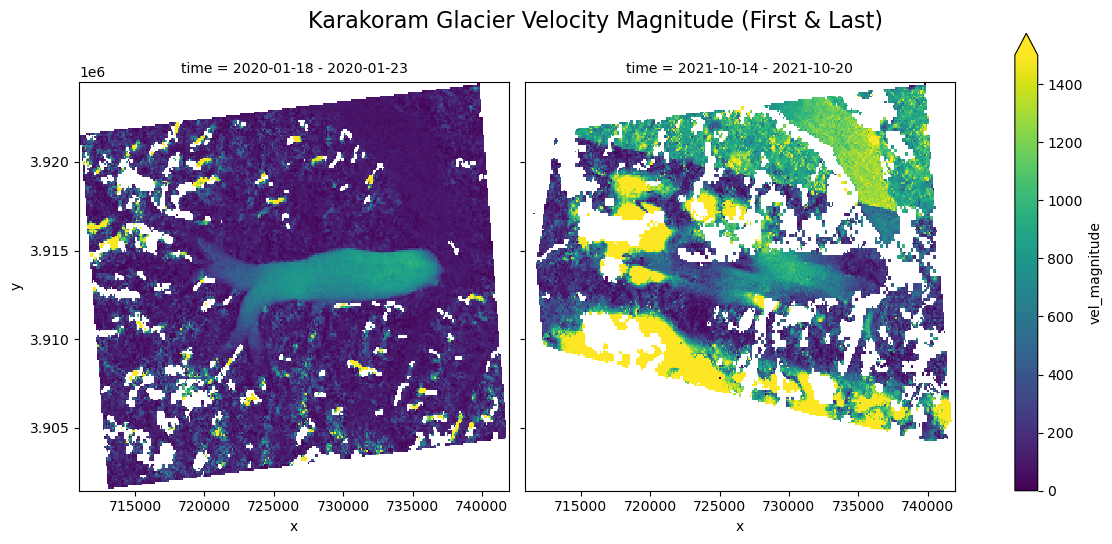

In [5]:
K_subset = trimmed.isel(time=[0, -1])

p = K_subset.vel_magnitude.plot(col="time", col_wrap=2, figsize=(12, 5.5), vmax=1500) 
p.fig.suptitle("Karakoram Glacier Velocity Magnitude (First & Last)", fontsize=16)
p.fig.subplots_adjust(top=0.85, right=0.8)

os.makedirs("figures", exist_ok=True)
p.fig.savefig("figures/K_firstandlast.png")
plt.show()

The plots above show the new first and last data images which match that of the Alaskan Glacier dataset (note that the interval is still not 100% the same since we used the data interval's midpoint date to calculate chronology).

In [19]:
mean_vx = trimmed.x_vel.mean(dim=['x','y'])
mean_vy = trimmed.y_vel.mean(dim=['x','y'])
mean_speed = trimmed.vel_magnitude.mean(dim=['x','y'])

summary_df = pd.DataFrame({
    'time': trimmed.time.values,
    'midpoint' : trimmed.mid_time.values,
    'mean_vx': mean_vx.values,
    'mean_vy': mean_vy.values,
    'mean_vel_magnitude': mean_speed.values})

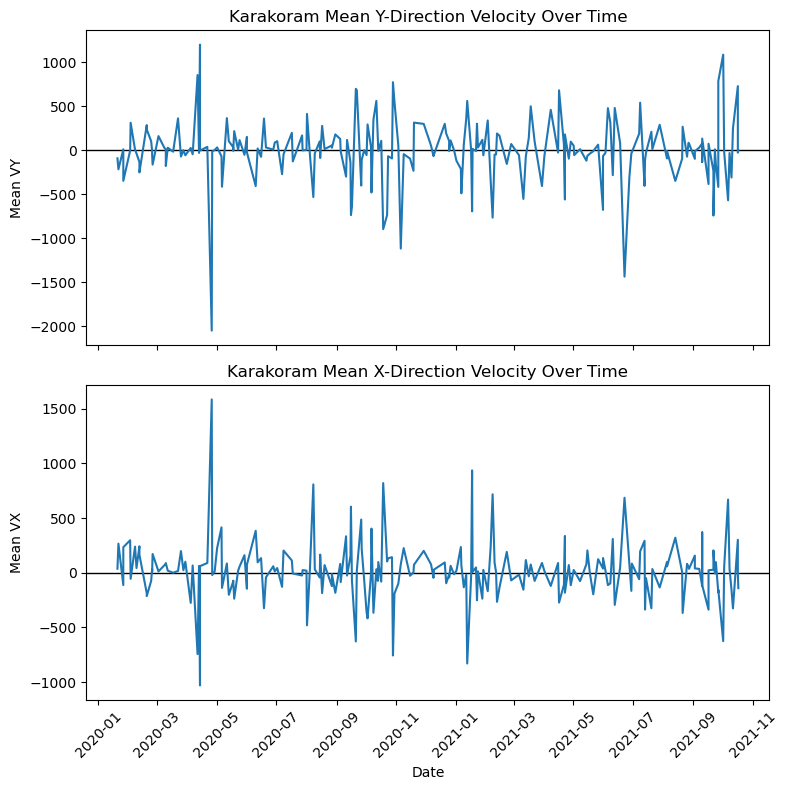

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)

ax[0].axhline(color='black', linewidth=1)
ax[0].plot(summary_df['midpoint'], summary_df['mean_vy'])
ax[0].set_ylabel('Mean VY')
ax[0].set_title('Karakoram Mean Y-Direction Velocity Over Time')

ax[1].axhline(color='black', linewidth=1)
ax[1].plot(summary_df['midpoint'], summary_df['mean_vx'])
ax[1].set_ylabel('Mean VX')
ax[1].set_title('Karakoram Mean X-Direction Velocity Over Time')

# Shared x-axis formatting
plt.xticks(rotation=45)
ax[1].set_xlabel('Date')

plt.tight_layout()
fig.savefig("figures/K_meanXY_chart.png", dpi=300, bbox_inches='tight')
plt.show()

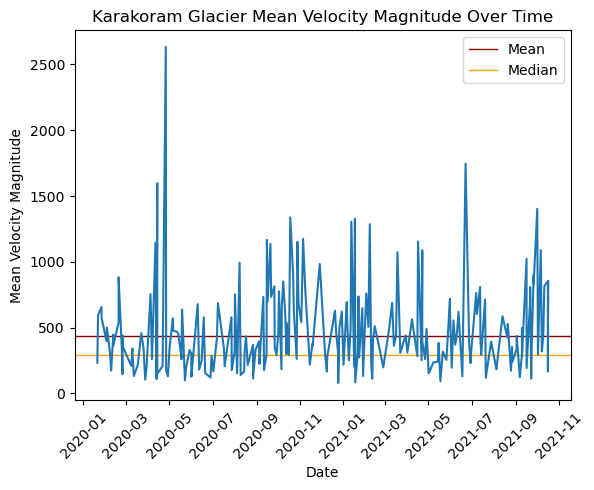

In [21]:
plt.axhline(y=trimmed['vel_magnitude'].mean(), color='darkred', linewidth=1, label="Mean")
plt.axhline(y=trimmed['vel_magnitude'].median(), color='orange', linewidth=1, label="Median")
plt.plot(summary_df['midpoint'], summary_df['mean_vel_magnitude'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Karakoram Glacier Mean Velocity Magnitude Over Time')
plt.legend()
plt.savefig("figures/K_meanmag_chart.png", dpi=300, bbox_inches='tight')
plt.show()

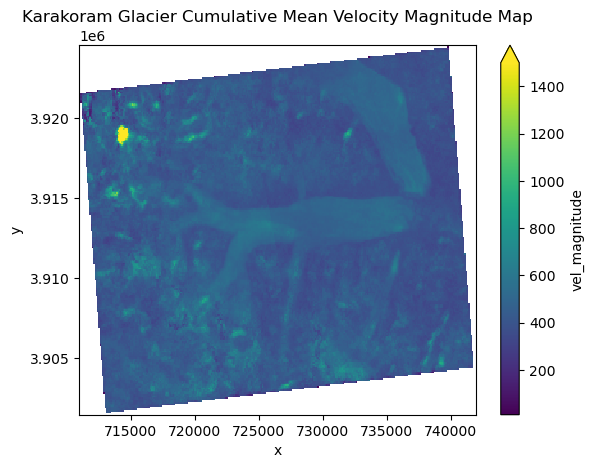

In [22]:
mean_vx_map = trimmed.x_vel.mean(dim='time')
mean_vy_map = trimmed.y_vel.mean(dim='time')
mean_vel_map = trimmed.vel_magnitude.mean(dim='time')

mean_vel_map.plot(vmax=1500)
plt.title('Karakoram Glacier Cumulative Mean Velocity Magnitude Map')
plt.savefig("figures/K_meanmag_map.png")
plt.show()

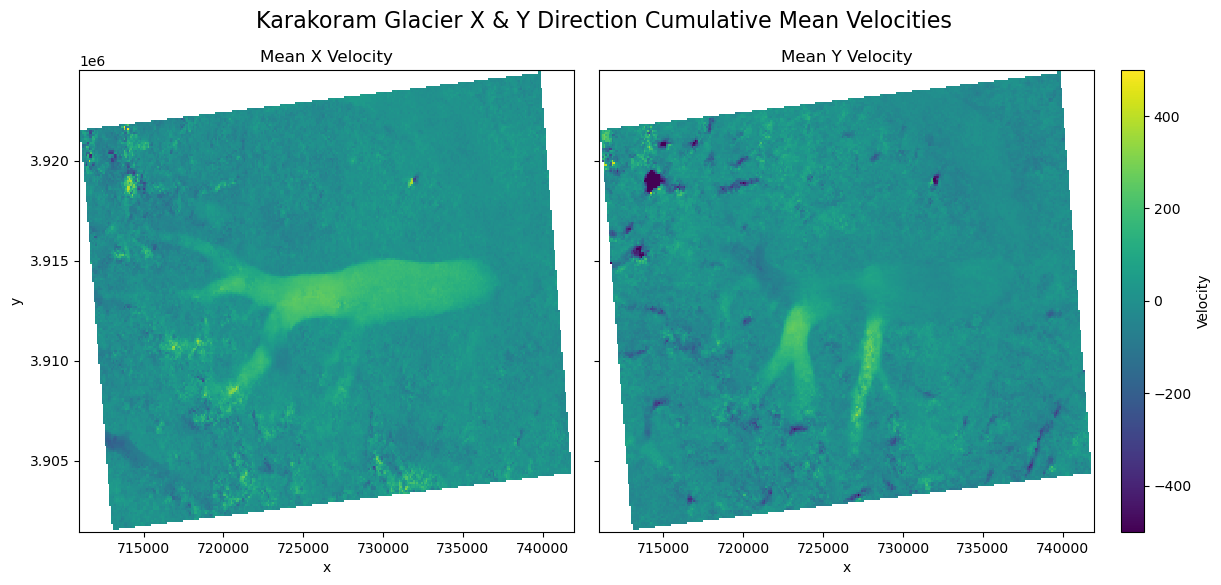

In [27]:
vmax = max((mean_vx_map).max(), (mean_vy_map).max())
vmin = min((mean_vx_map).min(), (mean_vy_map).min())

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

mappable = mean_vx_map.plot(ax=axes[0], vmin=-500, vmax=500, add_colorbar=False)
axes[0].set_title("Mean X Velocity")

mean_vy_map.plot(ax=axes[1], vmin=-500, vmax=500, add_colorbar=False)
axes[1].set_ylabel("")
axes[1].set_title("Mean Y Velocity")

cbar = fig.colorbar(mappable, ax=axes, orientation='vertical', fraction=0.04, pad=0.02)
cbar.set_label("Velocity")

plt.suptitle("Karakoram Glacier X & Y Direction Cumulative Mean Velocities", fontsize=16)
plt.subplots_adjust(wspace=0.05, right = 0.85)
plt.savefig("figures/K_meanXY_map.png")
plt.show()

Note that for these plots of mean X- and Y-direction velocities, the scale of the velocity range is much smaller than for the others. Since the data includes postive and negatie values, taking the mean centers the plotted values much closer to zero required a smaller scale to see the results more clearly.

In [28]:
monthly = trimmed.groupby("mid_time.month").mean()

monthly_mean_vx = monthly.x_vel.mean(dim=['x','y'])
monthly_mean_vy = monthly.y_vel.mean(dim=['x','y'])
monthly_mean_speed = monthly.vel_magnitude.mean(dim=['x','y'])

monthly_summary = pd.DataFrame({
    'month': monthly.month.values,
    'monthly_mean_vx': monthly_mean_vx.values,
    'monthly_mean_vy': monthly_mean_vy.values,
    'monthly_mean_vel_magnitude': monthly_mean_speed.values})

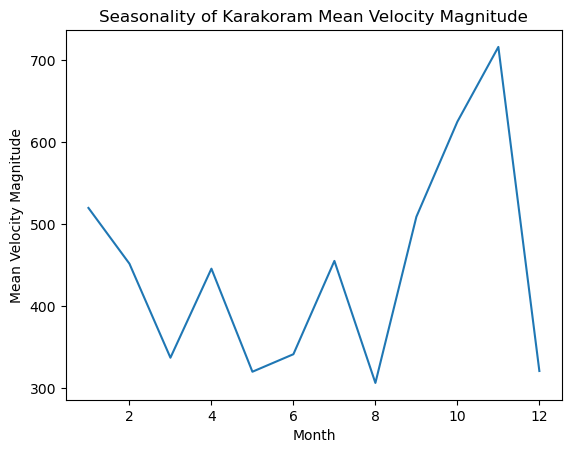

In [29]:
plt.plot(monthly_summary['month'], monthly_summary['monthly_mean_vel_magnitude'])
plt.xlabel('Month')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Seasonality of Karakoram Mean Velocity Magnitude')
plt.savefig("figures/K_seasonality_chart.png")
plt.show()

This plot shows the seasonality of the Karakoram glacier's velocity magnitude.

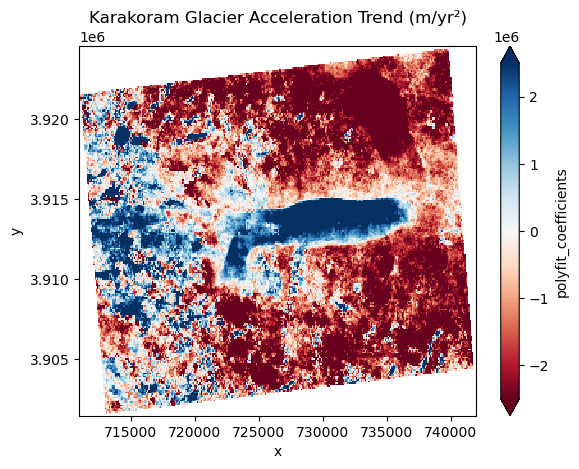

In [30]:
trend_map = trimmed.vel_magnitude.polyfit(dim="mid_time", deg=1)
slope_map = trend_map.polyfit_coefficients.sel(degree=0)
slope_map = slope_map * 365

slope_map.plot(cmap='RdBu', vmin=-2500000, vmax=2500000)
plt.title("Karakoram Glacier Acceleration Trend (m/yr²)")
plt.savefig("figures/K_acceleration_map.png")
plt.show()

This figure shows the Karakoram glacier's acceleration; the blue(positive) indicates acceleration while the red(negative) indicates deceleration.

In [31]:
vals = slope_map.values.flatten()
vals = vals[~np.isnan(vals)]
total = vals.size

neg  = np.sum(vals < 0)
pos  = np.sum(vals > 0)

pct_neg  = neg / total * 100
pct_pos  = pos / total * 100

print("%Neg:", pct_neg)
print("%Pos:", pct_pos)

%Neg: 72.33877901977644
%Pos: 27.66122098022356
